In [25]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

import seaborn as sns


from global_config import config
import pandas as pd
import numpy as np
import rpy2
import os

from datetime import date, timedelta

data_dir_mnps   = config.get_property('geo_dir')
data_dir        = config.get_property('data_dir')
fb_ppl_data     = config.get_property('covid_fb')
results_dir     = config.get_property('results_dir')
data_cases_path = os.path.join(fb_ppl_data, 'agglomerated', 'geometry')


In [26]:

# Defines lockdowns
no_lock_lab = "No Lockdown Imposed"
lock_lab    = "Lockdown Imposed"


lockdowns = []
lockdowns.append({"code": "A",
                  "start_date" : pd.to_datetime("2020-07-13"),
                  "end_date"   : pd.to_datetime("2020-07-23"),
                  "places":["chapinero",
                            "los_martires",
                            "san_cristobal",
                            "tunjuelito",
                            "rafel_uribe_uribe",
                            "ciudad_bolivar",
                            "santa_fe",
                            "usme"]})

lockdowns.append({"code": "B",
                  "start_date" : pd.to_datetime("2020-07-23"),
                  "end_date"   : pd.to_datetime("2020-08-06"),
                  "places":["bosa",
                            "antonio_narino",
                            "kennedy",
                            "puente_aranda",
                            "fontibon"]})

lockdowns.append({"code": "C",
                  "start_date" : pd.to_datetime("2020-07-31"),
                  "end_date"   : pd.to_datetime("2020-08-14"),
                  "places":["suba",
                            "engativa",
                            "barrios_unidos"]})

lockdowns.append({
                  "code": "D",
                  "start_date" : pd.to_datetime("2020-08-16"),
                  "end_date"   : pd.to_datetime("2020-08-27"),
                  "places":["usaquen",
                            "chapinero",
                            "santa_fe",
                            "candelaria",
                            "teusaquillo",
                           "puente_aranda",
                           "antonio_narino"]})



In [27]:
from shapely.geometry import Point, LineString
from shapely.ops import cascaded_union

from datetime import timedelta
import contextily as ctx

import geopandas as gpd
from shapely import wkt

def read_geo_df(path_to_geodf):
    df_geo = pd.read_csv(path_to_geodf)
    df_geo['geometry'] = df_geo['geometry'].apply(wkt.loads)
    df_geo = gpd.GeoDataFrame(df_geo, geometry='geometry')

    return df_geo


all_data_df  = pd.read_csv(os.path.join(results_dir, "all_percentual_change_merged.csv"), parse_dates=["date"])
sse_info_df  = pd.read_csv(os.path.join(results_dir, "data", "censo", "variables.csv"))
shp_df       = gpd.read_file(os.path.join(results_dir, "data", "censo", "censo.shp"))
shp_df       = shp_df[['CODIGO_MZN', 'lat', 'lon', 'ESTRATO_MO', 'IPM', 'localidad', 'geometry']]
shp_df       = shp_df.dropna()

path_to_bog_polygon = os.path.join(data_dir_mnps, 'localities', 'localities_shapefile.shp')


# Read bogota polygons divided by localities.
polygons_bog = gpd.read_file( path_to_bog_polygon )
polygons_bog = polygons_bog.rename(columns={'location_i': 'location_id'})



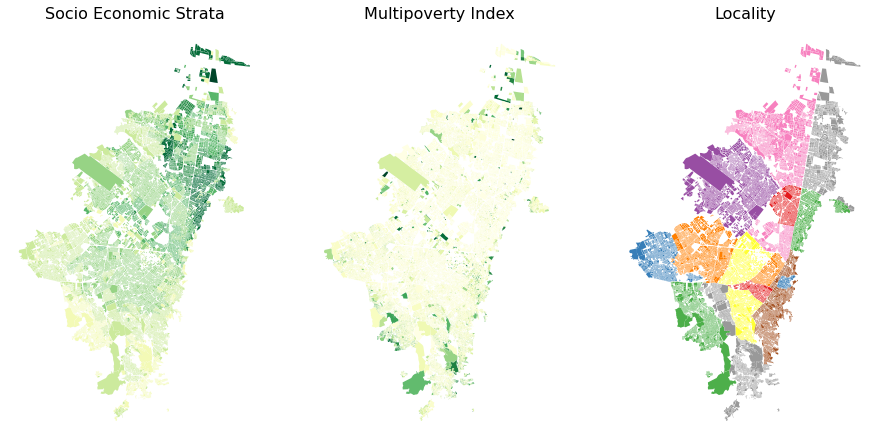

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(15.5, 20.5))
#polygons_bog.plot(ax=ax[0], edgecolor='black', alpha=0.3, facecolor='white', linewidth=1)
#polygons_bog.plot(ax=ax[1], edgecolor='black', alpha=0.3, facecolor='white', linewidth=1)
#polygons_bog.plot(ax=ax[2], edgecolor='black', alpha=0.3, facecolor='white', linewidth=1)


# Plot values as linestring
shp_df.plot(ax=ax[0], column='ESTRATO_MO', cmap="YlGn")
shp_df.plot(ax=ax[1], column='IPM', cmap="YlGn")
shp_df.plot(ax=ax[2], column='localidad', cmap="Set1")

ax[0].set_title("Socio Economic Strata", fontsize = 16)
ax[1].set_title("Multipoverty Index", fontsize = 16)
ax[2].set_title("Locality", fontsize = 16)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()



In [52]:
def plot_sse(ipm_list, sse, sse_counts, locality=None):
    fig, ax = plt.subplots(1, 2, figsize=(15.5, 7.2))

    ax[0].bar(sse, sse_counts, facecolor='gray', edgecolor='k', alpha=0.5)
    ax[1].hist(ipm_list, facecolor='green', edgecolor='k', alpha=0.5, density=True)

    ax[0].set_title(f'Socio Economic Strata | {locality}')
    ax[1].set_title(f'Multipoverty Index | {locality}')

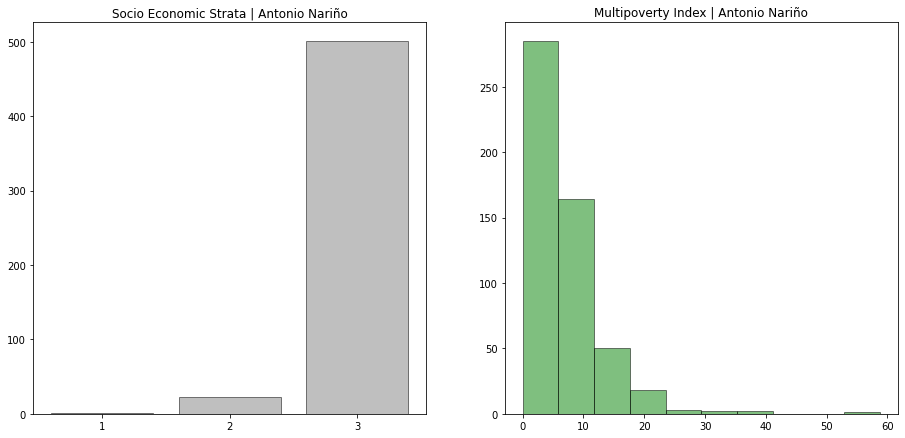

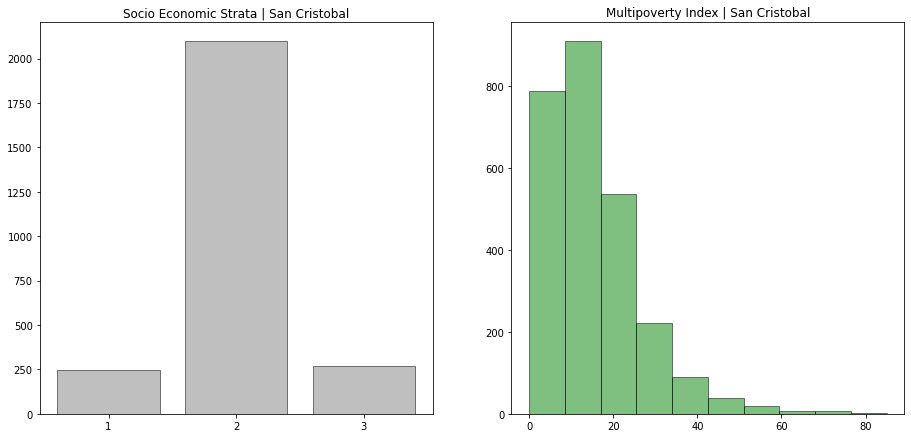

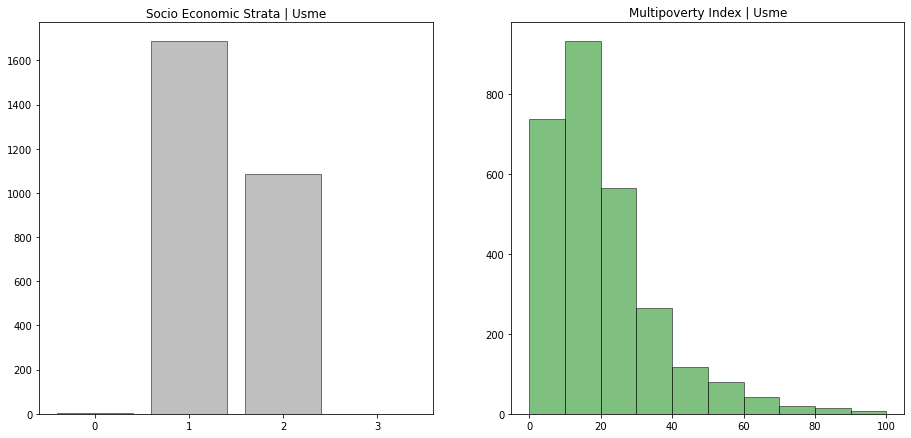

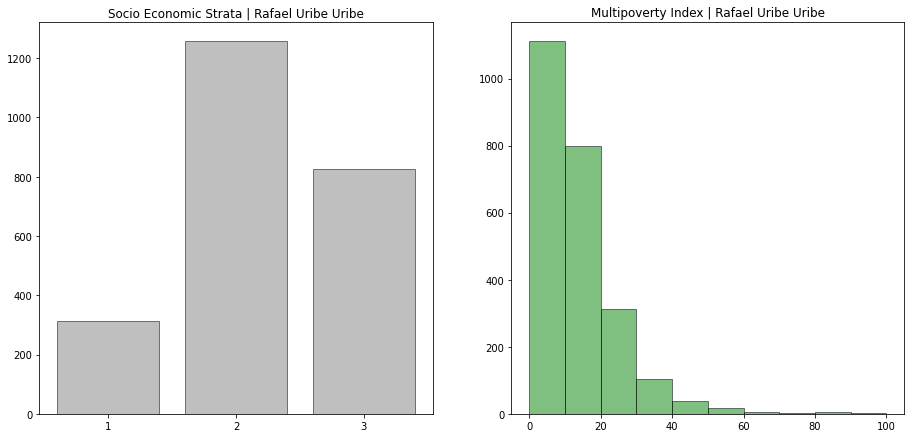

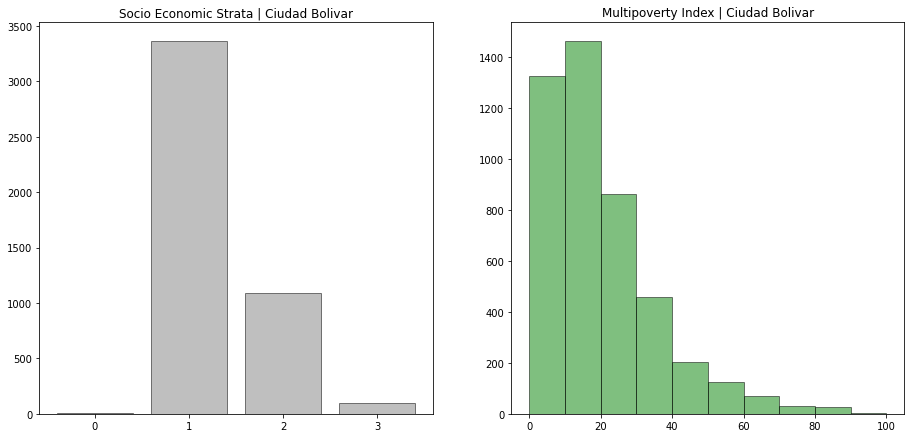

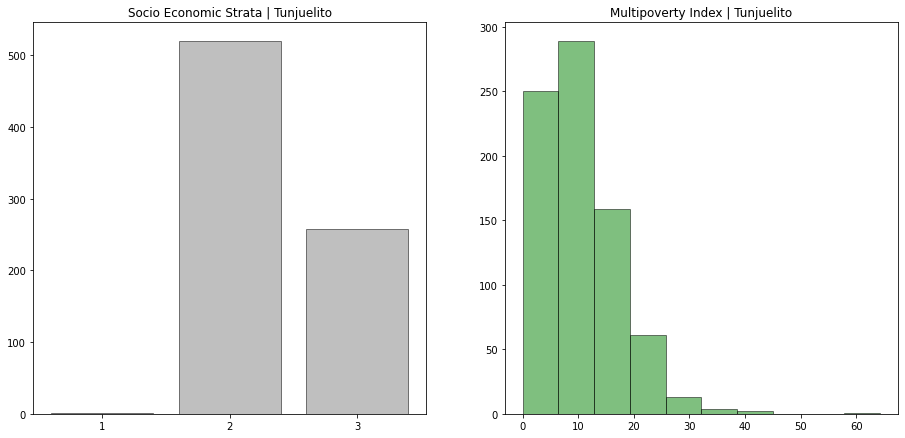

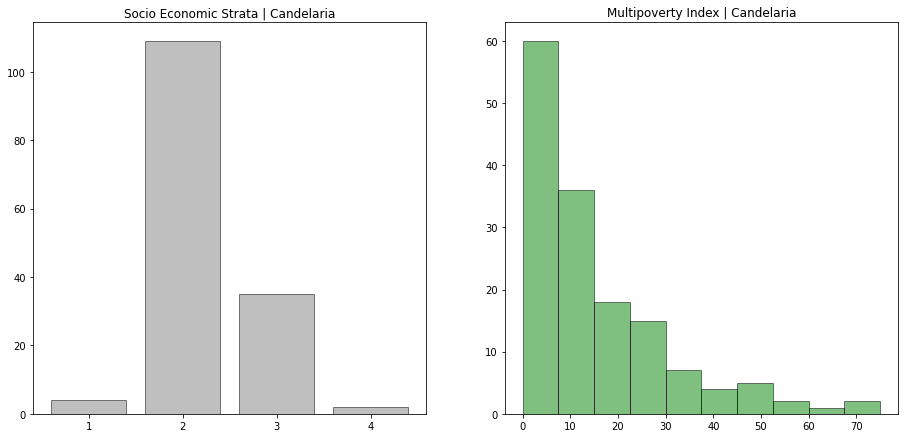

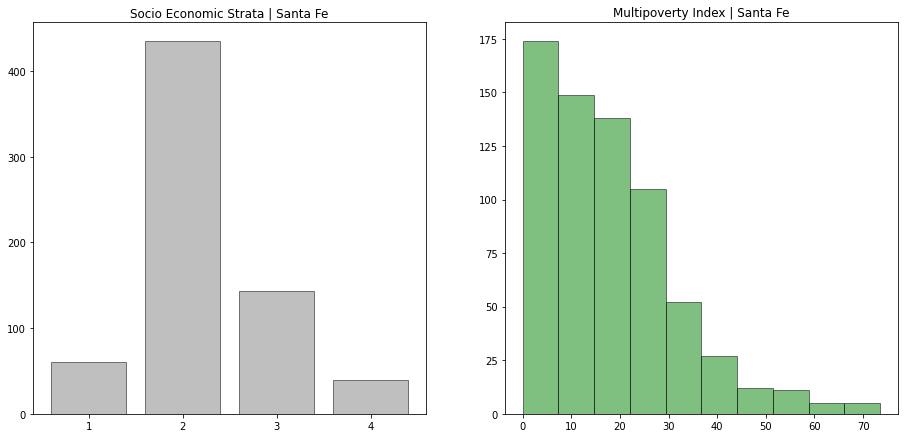

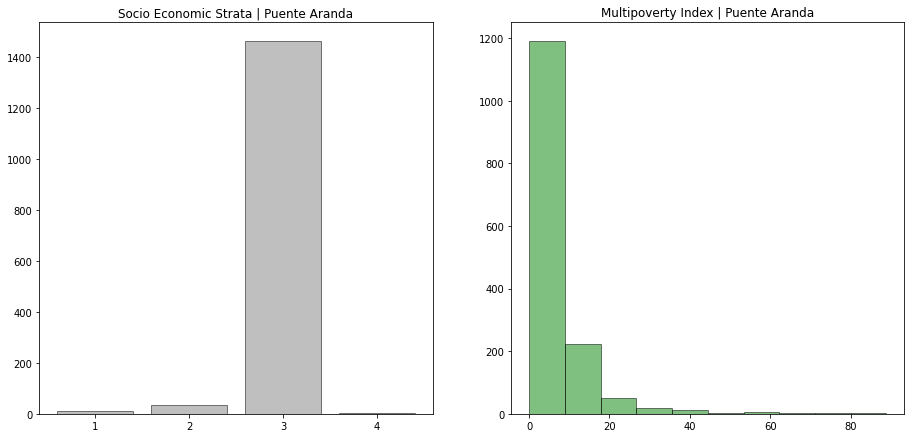

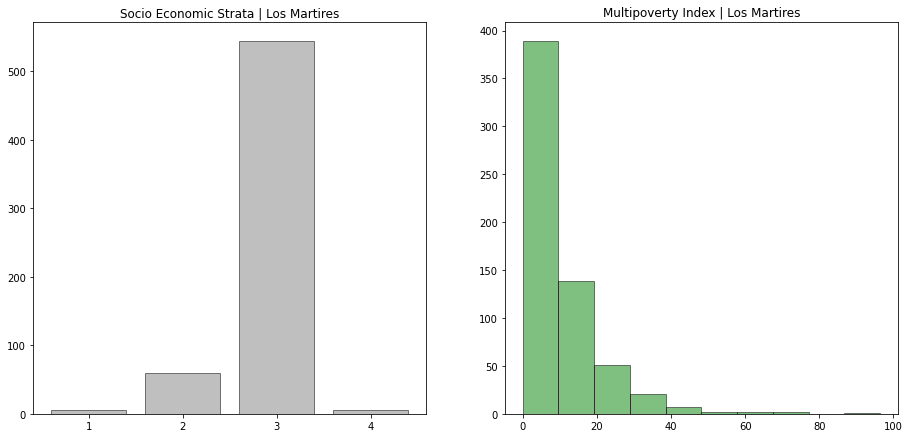

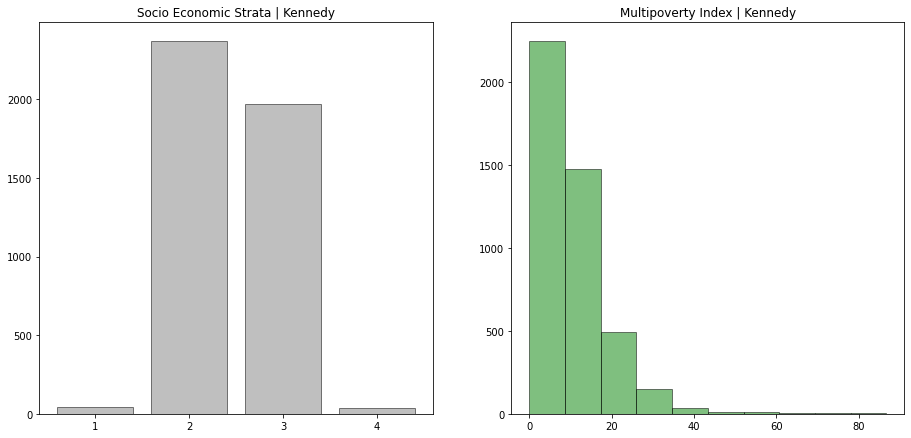

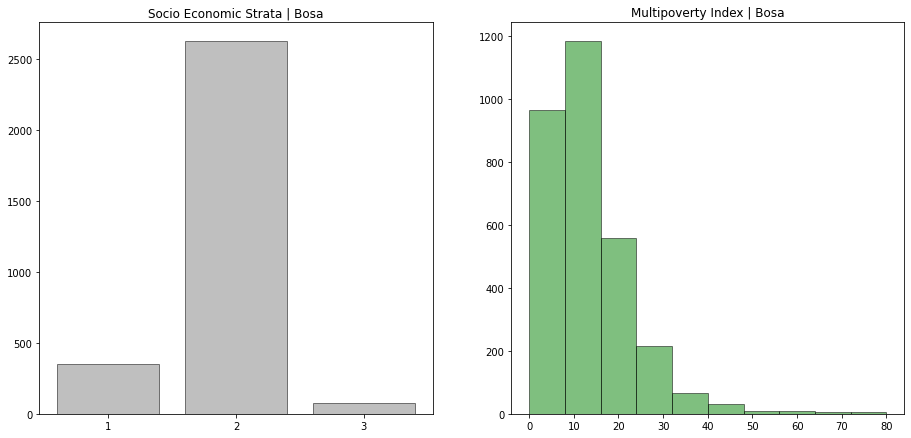

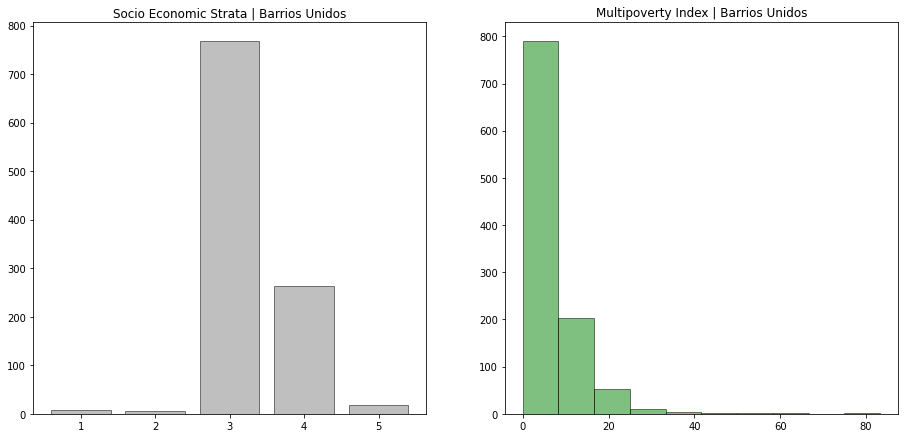

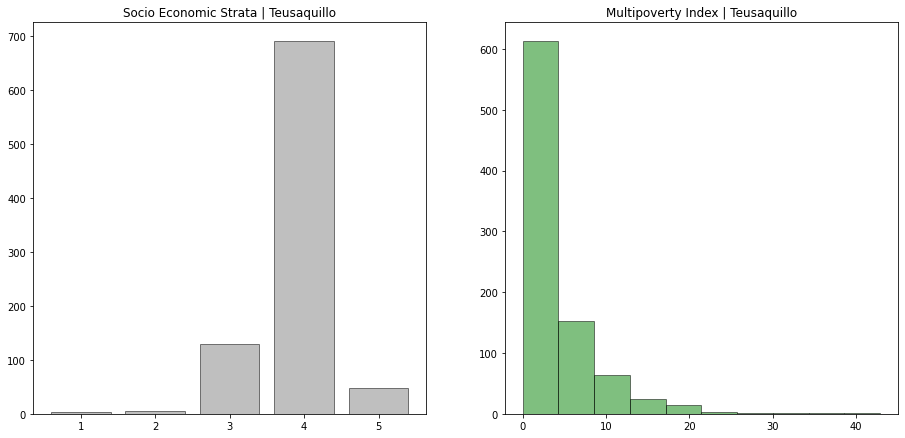

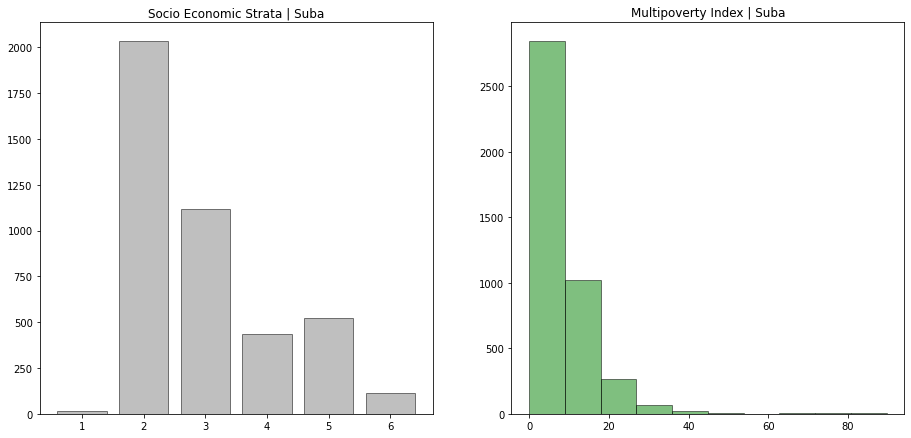

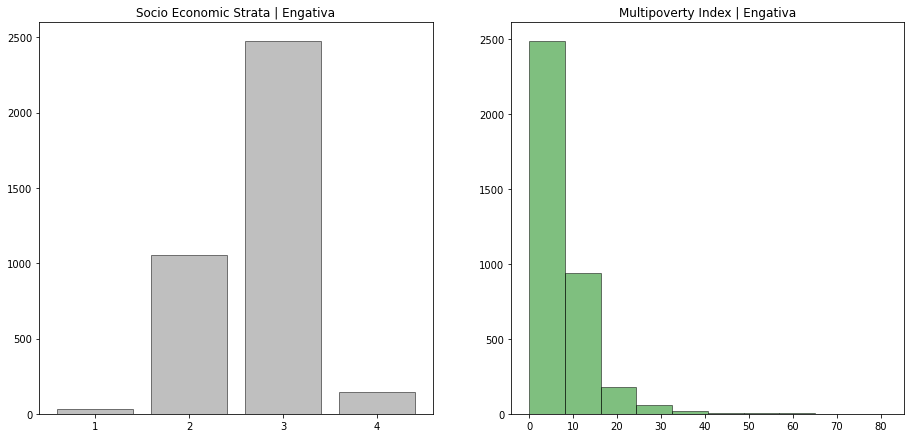

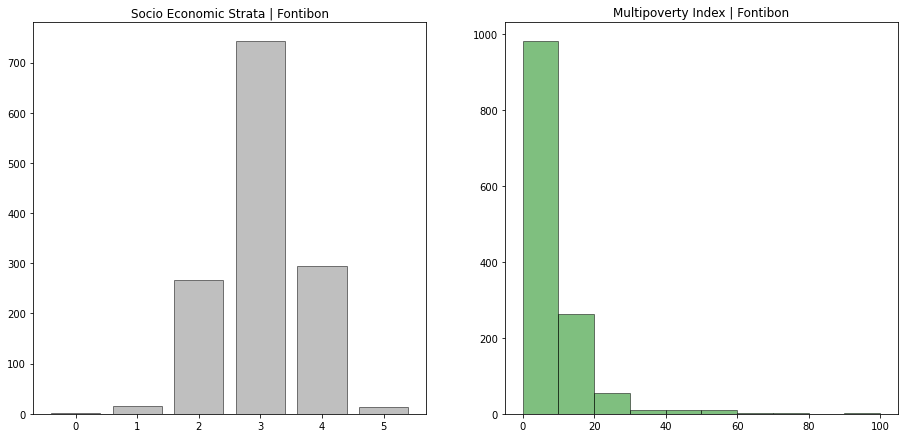

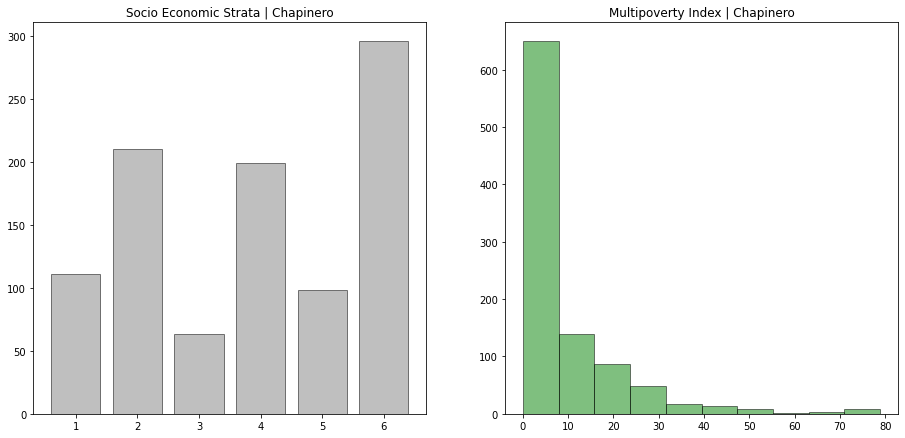

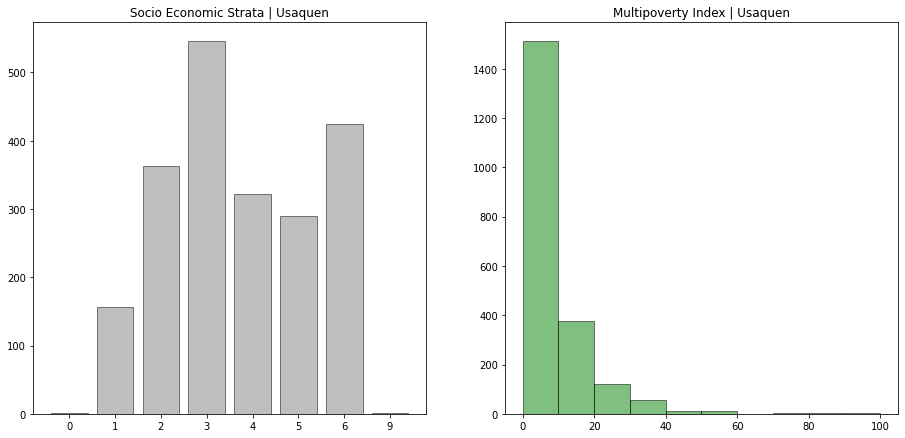

In [53]:
localidades_list = shp_df.localidad.unique()
for loc in localidades_list:
    loc_shp = shp_df[shp_df.localidad==loc]

    ipm, ipm_counts = np.unique(loc_shp.IPM, return_counts=True)
    sse, sse_counts = np.unique(loc_shp.ESTRATO_MO, return_counts=True)

    plot_sse(loc_shp.IPM, sse, sse_counts, locality=loc)



In [49]:
ipm

array([ 0. ,  0.6,  0.7,  0.9,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.8,
        1.9,  2. ,  2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,
        3. ,  3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,
        4.1,  4.2,  4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,
        5.2,  5.3,  5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,
        6.3,  6.4,  6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,
        7.4,  7.5,  7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,
        8.5,  8.6,  8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,
        9.6,  9.7,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7,
       10.8, 10.9, 11.2, 11.4, 11.5, 11.6, 11.8, 11.9, 12. , 12.1, 12.2,
       12.3, 12.5, 12.7, 12.9, 13.1, 13.2, 13.3, 13.4, 13.5, 13.7, 13.8,
       13.9, 14. , 14.3, 14.5, 14.6, 14.7, 14.8, 15. , 15.1, 15.4, 15.5,
       15.8, 16.1, 16.2, 16.5, 16.6, 16.7, 17. , 17.3, 17.4, 17.9, 18.8,
       18.9, 19.9, 20. , 20.7, 20.8, 21.3, 21.4, 21